# Group Number:

# Student 1: Ryan Meghoe

# Student 2: Nikita Jain

# Student 3: Andrei Rykov

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [3]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [4]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [5]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [6]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

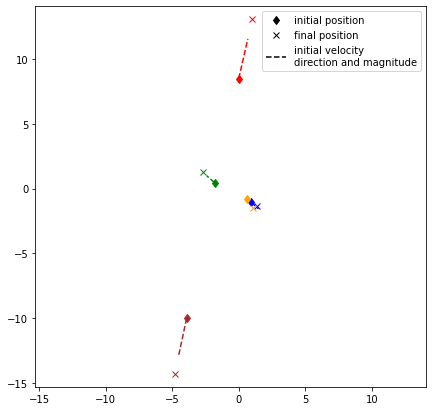

In [7]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [9]:
import torch

X_train = torch.cat((torch.tensor(positions_train[:,0,:,:]), torch.tensor(charges_train).squeeze(-1).unsqueeze(1)), dim=1)
X_train = torch.cat((X_train, torch.tensor(velocities_train).squeeze(1)), dim=1) # shape: (simulation id, parameters (x, y, c, v_x, v_y), particle id)
y_train = torch.tensor(positions_train[:,1:,:,:]) # shape: (simulation id, time (0.5, 1, 1.5), (x, y), particle id)

X_valid = torch.cat((torch.tensor(positions_valid[:,0,:,:]), torch.tensor(charges_valid).squeeze(-1).unsqueeze(1)), dim=1)
X_valid = torch.cat((X_valid, torch.tensor(velocities_valid).squeeze(1)), dim=1)
y_valid = torch.tensor(positions_valid[:,1:,:,:])

X_test = torch.cat((torch.tensor(positions_test[:,0,:,:]), torch.tensor(charges_test).squeeze(-1).unsqueeze(1)), dim=1)
X_test = torch.cat((X_test, torch.tensor(velocities_test).squeeze(1)), dim=1)
y_test = torch.tensor(positions_test[:,1:,:,:])

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch

batch_size = 64

X_subsample_100, _, y_subsample_100, _ = train_test_split(X_train, y_train, train_size=100)
X_subsample_1000, _, y_subsample_1000, _ = train_test_split(X_train, y_train, train_size=1000)
X_subsample_5000, _, y_subsample_5000, _ = train_test_split(X_train, y_train, train_size=5000)
X_subsample_10000, y_subsample_10000 = X_train, y_train

train_dataset_100 = TensorDataset(X_subsample_100, y_subsample_100)
train_dataset_1000 = TensorDataset(X_subsample_1000, y_subsample_1000)
train_dataset_5000 = TensorDataset(X_subsample_5000, y_subsample_5000)
train_dataset_10000 = TensorDataset(X_subsample_10000, y_subsample_10000)

valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

train100_dataloader = DataLoader(train_dataset_100, batch_size=batch_size, shuffle=True)
train1000_dataloader = DataLoader(train_dataset_1000, batch_size=batch_size, shuffle=True)
train5000_dataloader = DataLoader(train_dataset_5000, batch_size=batch_size, shuffle=True)
train10000_dataloader = DataLoader(train_dataset_10000, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Implementation

In [38]:
import torch
import torch.nn as nn

class MessageParsing(nn.Module):
    def __init__(self, set_size: int = 5, node_shape: int = 5, edge_shape: int = 1,
                 fau_output: int = 16, output_shape: int = 32,
                 device = torch.device('cpu')):
        super(MessageParsing, self).__init__()
        
        self.fau = nn.Sequential(nn.Linear(node_shape*2 + edge_shape, fau_output),
                                            nn.LeakyReLU())
        
        self.gamma = nn.Sequential(nn.Linear(fau_output + node_shape, output_shape),
                                   nn.LeakyReLU())
        
        self.fau_output = fau_output
        self.gamma_output = output_shape
        self.device = device
        
    def forward(self, x, edges):
        """
            x - input matrix of node features (batch_size, num_nodes, num_features)
            edge - input matrix of edge information (batch_size, num_nodes, num_nodes, num_features)
        """
        embeddings = torch.zeros((x.shape[0], x.shape[1], self.gamma_output)).to(self.device)
        
        for node in range(x.shape[1]):    
            temp = torch.cat([x[:,node,:].view(x.shape[0], 1, -1).repeat((1, x.shape[1] - 1, 1)),
                              x[:, list(set(range(x.shape[1])).difference({node})), :],
                              edges[:, node, list(set(range(x.shape[1])).difference({node})), :].view(x.shape[0], 
                                                                                                      x.shape[1]-1,
                                                                                                      -1)],
                            dim = -1)
            new = self.fau(temp)

            # aggregation function over dimension = 1 -- the whole neighborhood
            #new = new.mean(axis = 1)
            new = new.max(axis = 1).values
            
            new = torch.cat([x[:,node,:].view(x.shape[0], 1, -1),
                           new.view(x.shape[0], 1, -1)],
                           dim = 2)
            
            embeddings[:,node] = self.gamma(new).view(x.shape[0], -1)
        return embeddings

class ParticleModel(nn.Module):
    def __init__(self, input_shape: int = 5, set_size: int = 5, device = torch.device('cpu')):
        super(ParticleModel, self).__init__()
        self.iteration1 = MessageParsing(output_shape = 32, device=device)
        #self.iteration2 = MessageParsing(node_shape = 32, output_shape = 16, device = device)
        self.linear = nn.Sequential(nn.Linear(32, 2))
        self.device = device
           
    def forward(self, data):
        edges = torch.stack([torch.cdist(x_i, x_i) for x_i in data.swapaxes(1,2)], dim=0)\
                .view((data.shape[0], data.shape[1], data.shape[1], -1)).to(self.device)
        emb1 = self.iteration1(data.swapaxes(1,2), edges)
        #emb2 = self.iteration2(emb1, edges)
        out = self.linear(emb1)
        
        return out.swapaxes(1,2)

# Model Training

In [39]:
from tqdm import tqdm

class ParticleDistanceLoss(nn.Module):
    """
      The loss to calculate mean distance between predicted location of particle of each set.
      By defaul, Euclidean distance is set
    """

    def __init__(self, norm: float = 2):
        super(ParticleDistanceLoss, self).__init__()
        self.norm = norm

    def forward(self, input_set, target_set):
        """
            (batch_size, coordinates, set_size)
        """
        return (input_set - target_set).norm(p = self.norm, dim = 1).mean(axis = 1).mean()
        
        

class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 testing_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.testing_DataLoader = testing_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self, target_time):

        epoch_train_losses = []
        epoch_val_losses = []

        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}
        for epoch in tqdm(range(self.epochs)):
                 

            self.model.train()  # train mode

            train_losses=[]
            
            correct = 0
            length = 0
            for x, y in self.training_DataLoader:

                A, B = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                self.optimizer.zero_grad()  # zerograd the parameters

                loss = 0
                out = self.model(A)  # one forward pass

                loss += self.criterion(out, B[:,time_to_ind[target_time]])  # calculate loss
                
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters
            
            epoch_train_losses.append(np.mean(train_losses))
            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            correct = 0
            length = 0
            for x,  y in self.validation_DataLoader:

                A,B = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                with torch.no_grad():
                    loss = 0
                    
                    out = self.model(A)  # one forward pass
                    loss += self.criterion(out, B[:,time_to_ind[target_time]])  # calculate loss
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            epoch_val_losses.append(np.mean(valid_losses))
                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

        return epoch_train_losses, epoch_val_losses
        
    def evaluate_test(self, target_time):

        self.model.eval()
        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}

        with torch.no_grad():
            loss = []
            length = 0
            for x,y in self.testing_DataLoader:
                
                A, B = x.float().to(self.device), y.float().to(self.device)
                out = self.model(A)
                loss.append(self.criterion(out, B[:,time_to_ind[target_time]]))
        print(f'Test Error: {np.mean(loss):.4f} for target time {target_time}',end=' ')
        return np.mean(loss)
        
    def evaluate_train(self, target_time):

        self.model.eval()
        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}

        with torch.no_grad():
            loss = []
            length = 0
            for x,y in self.training_DataLoader:
                
                A, B = x.float().to(self.device), y.float().to(self.device)
                out = self.model(A)
                loss.append(self.criterion(out, B[:,time_to_ind[target_time]]))
        print(f'Training Error: {np.mean(loss):.4f} for target time {target_time}',end=' ')
        return np.mean(loss)

## Experiments

Using full training data

#### The mean aggregation of the node neighbourhood

In [36]:
import pandas as pd

results = pd.DataFrame()

In [37]:
times = [0.5, 1, 1.5]
time_to_ind = {0.5:0, 1:1, 1.5:2}

for train_dataloader, size in zip([train10000_dataloader, train5000_dataloader, train1000_dataloader, train100_dataloader],
                                    [10000, 5000, 1000, 100]):
    for time in times:
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device=torch.device('cpu')

        model = ParticleModel(device = device).to(device)
        criterion = ParticleDistanceLoss(norm=2)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        TrainingProcedure = Trainer(model, 
                                    device, 
                                    criterion, 
                                    optimizer,
                                    train_dataloader,
                                    valid_dataloader,
                                    test_dataloader,
                                    epochs = 20)

        train_loss, val_loss = TrainingProcedure.run_trainer(target_time=time)
        test_loss = TrainingProcedure.evaluate_test(target_time=time)
        train2_loss = TrainingProcedure.evaluate_train(target_time=time)
        results = results.append({'train size': size, 'time': time,
                                  'train_loss': train_loss[-1],
                                  'val_loss': val_loss[-1],
                                  'test_loss': test_loss,
                                  'train_eval': train2_loss,
                                  'agg': 'mean'},
                                 ignore_index = True)

  5%|████▏                                                                              | 1/20 [00:00<00:14,  1.30it/s]

EPOCH: 01/20 LOSS: 0.4025 VAL-LOSS: 0.2016


 10%|████████▎                                                                          | 2/20 [00:01<00:14,  1.27it/s]

EPOCH: 02/20 LOSS: 0.1843 VAL-LOSS: 0.1925


 15%|████████████▍                                                                      | 3/20 [00:02<00:13,  1.26it/s]

EPOCH: 03/20 LOSS: 0.1731 VAL-LOSS: 0.1938


 20%|████████████████▌                                                                  | 4/20 [00:03<00:12,  1.26it/s]

EPOCH: 04/20 LOSS: 0.1721 VAL-LOSS: 0.1630


 25%|████████████████████▊                                                              | 5/20 [00:03<00:11,  1.27it/s]

EPOCH: 05/20 LOSS: 0.1622 VAL-LOSS: 0.1662


 30%|████████████████████████▉                                                          | 6/20 [00:04<00:10,  1.27it/s]

EPOCH: 06/20 LOSS: 0.1637 VAL-LOSS: 0.1617


 35%|█████████████████████████████                                                      | 7/20 [00:05<00:10,  1.27it/s]

EPOCH: 07/20 LOSS: 0.1614 VAL-LOSS: 0.1604


 40%|█████████████████████████████████▏                                                 | 8/20 [00:06<00:09,  1.27it/s]

EPOCH: 08/20 LOSS: 0.1585 VAL-LOSS: 0.1661


 45%|█████████████████████████████████████▎                                             | 9/20 [00:07<00:08,  1.26it/s]

EPOCH: 09/20 LOSS: 0.1558 VAL-LOSS: 0.1625


 50%|█████████████████████████████████████████                                         | 10/20 [00:07<00:07,  1.25it/s]

EPOCH: 10/20 LOSS: 0.1552 VAL-LOSS: 0.1592


 55%|█████████████████████████████████████████████                                     | 11/20 [00:08<00:07,  1.24it/s]

EPOCH: 11/20 LOSS: 0.1520 VAL-LOSS: 0.1412


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:09<00:06,  1.25it/s]

EPOCH: 12/20 LOSS: 0.1450 VAL-LOSS: 0.1410


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:10<00:05,  1.26it/s]

EPOCH: 13/20 LOSS: 0.1441 VAL-LOSS: 0.1588


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:11<00:04,  1.27it/s]

EPOCH: 14/20 LOSS: 0.1421 VAL-LOSS: 0.1425


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:11<00:03,  1.27it/s]

EPOCH: 15/20 LOSS: 0.1405 VAL-LOSS: 0.1538


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:12<00:03,  1.26it/s]

EPOCH: 16/20 LOSS: 0.1414 VAL-LOSS: 0.1304


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:13<00:02,  1.27it/s]

EPOCH: 17/20 LOSS: 0.1409 VAL-LOSS: 0.1356


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:14<00:01,  1.28it/s]

EPOCH: 18/20 LOSS: 0.1408 VAL-LOSS: 0.1432


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:15<00:00,  1.26it/s]

EPOCH: 19/20 LOSS: 0.1372 VAL-LOSS: 0.1348


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.26it/s]

EPOCH: 20/20 LOSS: 0.1392 VAL-LOSS: 0.1367
Test Error: 0.1394 for target time 0.5 

Training Error: 0.1386 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:00<00:14,  1.28it/s]

EPOCH: 01/20 LOSS: 0.6051 VAL-LOSS: 0.3623


 10%|████████▎                                                                          | 2/20 [00:01<00:14,  1.26it/s]

EPOCH: 02/20 LOSS: 0.3573 VAL-LOSS: 0.3520


 15%|████████████▍                                                                      | 3/20 [00:02<00:13,  1.26it/s]

EPOCH: 03/20 LOSS: 0.3384 VAL-LOSS: 0.3130


 20%|████████████████▌                                                                  | 4/20 [00:03<00:12,  1.23it/s]

EPOCH: 04/20 LOSS: 0.3090 VAL-LOSS: 0.2965


 25%|████████████████████▊                                                              | 5/20 [00:04<00:12,  1.23it/s]

EPOCH: 05/20 LOSS: 0.2929 VAL-LOSS: 0.2920


 30%|████████████████████████▉                                                          | 6/20 [00:04<00:11,  1.23it/s]

EPOCH: 06/20 LOSS: 0.2918 VAL-LOSS: 0.2778


 35%|█████████████████████████████                                                      | 7/20 [00:05<00:10,  1.23it/s]

EPOCH: 07/20 LOSS: 0.2873 VAL-LOSS: 0.2872


 40%|█████████████████████████████████▏                                                 | 8/20 [00:06<00:09,  1.24it/s]

EPOCH: 08/20 LOSS: 0.2825 VAL-LOSS: 0.2825


 45%|█████████████████████████████████████▎                                             | 9/20 [00:07<00:08,  1.23it/s]

EPOCH: 09/20 LOSS: 0.2782 VAL-LOSS: 0.2901


 50%|█████████████████████████████████████████                                         | 10/20 [00:08<00:08,  1.22it/s]

EPOCH: 10/20 LOSS: 0.2778 VAL-LOSS: 0.2747


 55%|█████████████████████████████████████████████                                     | 11/20 [00:08<00:07,  1.22it/s]

EPOCH: 11/20 LOSS: 0.2769 VAL-LOSS: 0.2654


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:09<00:06,  1.21it/s]

EPOCH: 12/20 LOSS: 0.2746 VAL-LOSS: 0.2810


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:10<00:05,  1.22it/s]

EPOCH: 13/20 LOSS: 0.2730 VAL-LOSS: 0.2682


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:11<00:04,  1.21it/s]

EPOCH: 14/20 LOSS: 0.2737 VAL-LOSS: 0.2691


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:12<00:04,  1.22it/s]

EPOCH: 15/20 LOSS: 0.2686 VAL-LOSS: 0.2748


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:13<00:03,  1.22it/s]

EPOCH: 16/20 LOSS: 0.2708 VAL-LOSS: 0.2722


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:13<00:02,  1.21it/s]

EPOCH: 17/20 LOSS: 0.2715 VAL-LOSS: 0.2691


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:14<00:01,  1.22it/s]

EPOCH: 18/20 LOSS: 0.2705 VAL-LOSS: 0.2658


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:15<00:00,  1.22it/s]

EPOCH: 19/20 LOSS: 0.2659 VAL-LOSS: 0.2684


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.22it/s]

EPOCH: 20/20 LOSS: 0.2696 VAL-LOSS: 0.2647
Test Error: 0.2723 for target time 1 

Training Error: 0.2684 for target time 1 

  5%|████▏                                                                              | 1/20 [00:00<00:15,  1.21it/s]

EPOCH: 01/20 LOSS: 0.8137 VAL-LOSS: 0.5680


 10%|████████▎                                                                          | 2/20 [00:01<00:14,  1.23it/s]

EPOCH: 02/20 LOSS: 0.5417 VAL-LOSS: 0.5303


 15%|████████████▍                                                                      | 3/20 [00:02<00:13,  1.24it/s]

EPOCH: 03/20 LOSS: 0.4665 VAL-LOSS: 0.4460


 20%|████████████████▌                                                                  | 4/20 [00:03<00:12,  1.24it/s]

EPOCH: 04/20 LOSS: 0.4439 VAL-LOSS: 0.4353


 25%|████████████████████▊                                                              | 5/20 [00:04<00:12,  1.24it/s]

EPOCH: 05/20 LOSS: 0.4324 VAL-LOSS: 0.4282


 30%|████████████████████████▉                                                          | 6/20 [00:04<00:11,  1.23it/s]

EPOCH: 06/20 LOSS: 0.4267 VAL-LOSS: 0.4237


 35%|█████████████████████████████                                                      | 7/20 [00:05<00:10,  1.22it/s]

EPOCH: 07/20 LOSS: 0.4196 VAL-LOSS: 0.4200


 40%|█████████████████████████████████▏                                                 | 8/20 [00:06<00:09,  1.23it/s]

EPOCH: 08/20 LOSS: 0.4150 VAL-LOSS: 0.4184


 45%|█████████████████████████████████████▎                                             | 9/20 [00:07<00:08,  1.24it/s]

EPOCH: 09/20 LOSS: 0.4126 VAL-LOSS: 0.4110


 50%|█████████████████████████████████████████                                         | 10/20 [00:08<00:08,  1.24it/s]

EPOCH: 10/20 LOSS: 0.4084 VAL-LOSS: 0.4211


 55%|█████████████████████████████████████████████                                     | 11/20 [00:08<00:07,  1.24it/s]

EPOCH: 11/20 LOSS: 0.4037 VAL-LOSS: 0.4095


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:09<00:06,  1.24it/s]

EPOCH: 12/20 LOSS: 0.4082 VAL-LOSS: 0.4029


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:10<00:05,  1.22it/s]

EPOCH: 13/20 LOSS: 0.4010 VAL-LOSS: 0.3927


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:11<00:04,  1.22it/s]

EPOCH: 14/20 LOSS: 0.3992 VAL-LOSS: 0.3941


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:12<00:04,  1.21it/s]

EPOCH: 15/20 LOSS: 0.3980 VAL-LOSS: 0.4039


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:13<00:03,  1.21it/s]

EPOCH: 16/20 LOSS: 0.3973 VAL-LOSS: 0.3980


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:13<00:02,  1.22it/s]

EPOCH: 17/20 LOSS: 0.3942 VAL-LOSS: 0.4038


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:14<00:01,  1.25it/s]

EPOCH: 18/20 LOSS: 0.3894 VAL-LOSS: 0.3880


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:15<00:00,  1.23it/s]

EPOCH: 19/20 LOSS: 0.3902 VAL-LOSS: 0.3965


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:16<00:00,  1.23it/s]

EPOCH: 20/20 LOSS: 0.3876 VAL-LOSS: 0.4162
Test Error: 0.4191 for target time 1.5 

Training Error: 0.4132 for target time 1.5 

  5%|████▏                                                                              | 1/20 [00:00<00:08,  2.29it/s]

EPOCH: 01/20 LOSS: 0.6209 VAL-LOSS: 0.1908


 10%|████████▎                                                                          | 2/20 [00:00<00:08,  2.24it/s]

EPOCH: 02/20 LOSS: 0.1890 VAL-LOSS: 0.1692


 15%|████████████▍                                                                      | 3/20 [00:01<00:07,  2.22it/s]

EPOCH: 03/20 LOSS: 0.1694 VAL-LOSS: 0.1622


 20%|████████████████▌                                                                  | 4/20 [00:01<00:07,  2.18it/s]

EPOCH: 04/20 LOSS: 0.1593 VAL-LOSS: 0.1632


 25%|████████████████████▊                                                              | 5/20 [00:02<00:06,  2.19it/s]

EPOCH: 05/20 LOSS: 0.1586 VAL-LOSS: 0.1484


 30%|████████████████████████▉                                                          | 6/20 [00:02<00:06,  2.22it/s]

EPOCH: 06/20 LOSS: 0.1511 VAL-LOSS: 0.1464


 35%|█████████████████████████████                                                      | 7/20 [00:03<00:05,  2.24it/s]

EPOCH: 07/20 LOSS: 0.1482 VAL-LOSS: 0.1550


 40%|█████████████████████████████████▏                                                 | 8/20 [00:03<00:05,  2.20it/s]

EPOCH: 08/20 LOSS: 0.1470 VAL-LOSS: 0.1443


 45%|█████████████████████████████████████▎                                             | 9/20 [00:04<00:04,  2.22it/s]

EPOCH: 09/20 LOSS: 0.1447 VAL-LOSS: 0.1545


 50%|█████████████████████████████████████████                                         | 10/20 [00:04<00:04,  2.23it/s]

EPOCH: 10/20 LOSS: 0.1481 VAL-LOSS: 0.1426


 55%|█████████████████████████████████████████████                                     | 11/20 [00:04<00:03,  2.26it/s]

EPOCH: 11/20 LOSS: 0.1426 VAL-LOSS: 0.1453


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:05<00:03,  2.26it/s]

EPOCH: 12/20 LOSS: 0.1441 VAL-LOSS: 0.1457


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:05<00:03,  2.27it/s]

EPOCH: 13/20 LOSS: 0.1441 VAL-LOSS: 0.1478


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:06<00:02,  2.27it/s]

EPOCH: 14/20 LOSS: 0.1426 VAL-LOSS: 0.1428


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:06<00:02,  2.27it/s]

EPOCH: 15/20 LOSS: 0.1475 VAL-LOSS: 0.1528


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:07<00:01,  2.27it/s]

EPOCH: 16/20 LOSS: 0.1419 VAL-LOSS: 0.1410


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:07<00:01,  2.27it/s]

EPOCH: 17/20 LOSS: 0.1453 VAL-LOSS: 0.1394


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:08<00:00,  2.27it/s]

EPOCH: 18/20 LOSS: 0.1431 VAL-LOSS: 0.1549


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:08<00:00,  2.28it/s]

EPOCH: 19/20 LOSS: 0.1440 VAL-LOSS: 0.1546


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.25it/s]

EPOCH: 20/20 LOSS: 0.1432 VAL-LOSS: 0.1358
Test Error: 0.1391 for target time 0.5 

Training Error: 0.1366 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:00<00:08,  2.35it/s]

EPOCH: 01/20 LOSS: 0.8401 VAL-LOSS: 0.3867


 10%|████████▎                                                                          | 2/20 [00:00<00:07,  2.31it/s]

EPOCH: 02/20 LOSS: 0.3822 VAL-LOSS: 0.3728


 15%|████████████▍                                                                      | 3/20 [00:01<00:07,  2.29it/s]

EPOCH: 03/20 LOSS: 0.3589 VAL-LOSS: 0.3594


 20%|████████████████▌                                                                  | 4/20 [00:01<00:06,  2.29it/s]

EPOCH: 04/20 LOSS: 0.3442 VAL-LOSS: 0.3548


 25%|████████████████████▊                                                              | 5/20 [00:02<00:06,  2.28it/s]

EPOCH: 05/20 LOSS: 0.3194 VAL-LOSS: 0.3076


 30%|████████████████████████▉                                                          | 6/20 [00:02<00:06,  2.28it/s]

EPOCH: 06/20 LOSS: 0.3055 VAL-LOSS: 0.3079


 35%|█████████████████████████████                                                      | 7/20 [00:03<00:05,  2.25it/s]

EPOCH: 07/20 LOSS: 0.2993 VAL-LOSS: 0.2914


 40%|█████████████████████████████████▏                                                 | 8/20 [00:03<00:05,  2.21it/s]

EPOCH: 08/20 LOSS: 0.2941 VAL-LOSS: 0.2951


 45%|█████████████████████████████████████▎                                             | 9/20 [00:04<00:05,  2.18it/s]

EPOCH: 09/20 LOSS: 0.2964 VAL-LOSS: 0.3032


 50%|█████████████████████████████████████████                                         | 10/20 [00:04<00:04,  2.21it/s]

EPOCH: 10/20 LOSS: 0.2887 VAL-LOSS: 0.3021


 55%|█████████████████████████████████████████████                                     | 11/20 [00:04<00:04,  2.23it/s]

EPOCH: 11/20 LOSS: 0.2857 VAL-LOSS: 0.2907


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:05<00:03,  2.18it/s]

EPOCH: 12/20 LOSS: 0.2859 VAL-LOSS: 0.2917


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:05<00:03,  2.20it/s]

EPOCH: 13/20 LOSS: 0.2837 VAL-LOSS: 0.2756


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:06<00:02,  2.20it/s]

EPOCH: 14/20 LOSS: 0.2808 VAL-LOSS: 0.2881


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:06<00:02,  2.20it/s]

EPOCH: 15/20 LOSS: 0.2791 VAL-LOSS: 0.2879


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:07<00:01,  2.20it/s]

EPOCH: 16/20 LOSS: 0.2826 VAL-LOSS: 0.2884


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:07<00:01,  2.20it/s]

EPOCH: 17/20 LOSS: 0.2825 VAL-LOSS: 0.2724


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:08<00:00,  2.20it/s]

EPOCH: 18/20 LOSS: 0.2771 VAL-LOSS: 0.2813


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:08<00:00,  2.20it/s]

EPOCH: 19/20 LOSS: 0.2814 VAL-LOSS: 0.2808


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.23it/s]

EPOCH: 20/20 LOSS: 0.2756 VAL-LOSS: 0.2799
Test Error: 0.2861 for target time 1 

Training Error: 0.2804 for target time 1 

  5%|████▏                                                                              | 1/20 [00:00<00:08,  2.28it/s]

EPOCH: 01/20 LOSS: 1.0489 VAL-LOSS: 0.6023


 10%|████████▎                                                                          | 2/20 [00:00<00:07,  2.28it/s]

EPOCH: 02/20 LOSS: 0.5691 VAL-LOSS: 0.5878


 15%|████████████▍                                                                      | 3/20 [00:01<00:07,  2.24it/s]

EPOCH: 03/20 LOSS: 0.5597 VAL-LOSS: 0.5523


 20%|████████████████▌                                                                  | 4/20 [00:01<00:07,  2.22it/s]

EPOCH: 04/20 LOSS: 0.5284 VAL-LOSS: 0.5382


 25%|████████████████████▊                                                              | 5/20 [00:02<00:06,  2.24it/s]

EPOCH: 05/20 LOSS: 0.5131 VAL-LOSS: 0.5237


 30%|████████████████████████▉                                                          | 6/20 [00:02<00:06,  2.23it/s]

EPOCH: 06/20 LOSS: 0.4984 VAL-LOSS: 0.5032


 35%|█████████████████████████████                                                      | 7/20 [00:03<00:05,  2.24it/s]

EPOCH: 07/20 LOSS: 0.4808 VAL-LOSS: 0.4716


 40%|█████████████████████████████████▏                                                 | 8/20 [00:03<00:05,  2.23it/s]

EPOCH: 08/20 LOSS: 0.4728 VAL-LOSS: 0.4483


 45%|█████████████████████████████████████▎                                             | 9/20 [00:04<00:04,  2.23it/s]

EPOCH: 09/20 LOSS: 0.4438 VAL-LOSS: 0.4384


 50%|█████████████████████████████████████████                                         | 10/20 [00:04<00:04,  2.26it/s]

EPOCH: 10/20 LOSS: 0.4463 VAL-LOSS: 0.4428


 55%|█████████████████████████████████████████████                                     | 11/20 [00:04<00:04,  2.24it/s]

EPOCH: 11/20 LOSS: 0.4376 VAL-LOSS: 0.4733


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:05<00:03,  2.23it/s]

EPOCH: 12/20 LOSS: 0.4397 VAL-LOSS: 0.4323


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:05<00:03,  2.24it/s]

EPOCH: 13/20 LOSS: 0.4363 VAL-LOSS: 0.4592


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:06<00:02,  2.25it/s]

EPOCH: 14/20 LOSS: 0.4311 VAL-LOSS: 0.4332


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:06<00:02,  2.24it/s]

EPOCH: 15/20 LOSS: 0.4268 VAL-LOSS: 0.4402


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:07<00:01,  2.25it/s]

EPOCH: 16/20 LOSS: 0.4287 VAL-LOSS: 0.4423


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:07<00:01,  2.23it/s]

EPOCH: 17/20 LOSS: 0.4260 VAL-LOSS: 0.4236


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:08<00:00,  2.24it/s]

EPOCH: 18/20 LOSS: 0.4195 VAL-LOSS: 0.4198


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:08<00:00,  2.26it/s]

EPOCH: 19/20 LOSS: 0.4188 VAL-LOSS: 0.4168


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  2.25it/s]

EPOCH: 20/20 LOSS: 0.4136 VAL-LOSS: 0.4266
Test Error: 0.4318 for target time 1.5 

Training Error: 0.4201 for target time 1.5 

  5%|████▏                                                                              | 1/20 [00:00<00:03,  5.70it/s]

EPOCH: 01/20 LOSS: 1.9491 VAL-LOSS: 0.7690


 10%|████████▎                                                                          | 2/20 [00:00<00:03,  5.75it/s]

EPOCH: 02/20 LOSS: 0.5502 VAL-LOSS: 0.3513
EPOCH: 03/20 LOSS: 0.2978

 20%|████████████████▌                                                                  | 4/20 [00:00<00:02,  5.96it/s]

 VAL-LOSS: 0.2407
EPOCH: 04/20 LOSS: 0.2314 VAL-LOSS: 0.2269


 30%|████████████████████████▉                                                          | 6/20 [00:01<00:02,  6.06it/s]

EPOCH: 05/20 LOSS: 0.2162 VAL-LOSS: 0.2003
EPOCH: 06/20 LOSS: 0.2083 VAL-LOSS: 0.1962


 40%|█████████████████████████████████▏                                                 | 8/20 [00:01<00:02,  5.91it/s]

EPOCH: 07/20 LOSS: 0.2018 VAL-LOSS: 0.1924
EPOCH: 08/20 LOSS: 0.1983 VAL-LOSS: 0.1822


 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  6.15it/s]

EPOCH: 09/20 LOSS: 0.1918 VAL-LOSS: 0.2033
EPOCH: 10/20 LOSS: 0.1885 VAL-LOSS: 0.1780


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:01<00:01,  6.13it/s]

EPOCH: 11/20 LOSS: 0.1836 VAL-LOSS: 0.1859
EPOCH: 12/20 LOSS: 0.1785 VAL-LOSS: 0.1815


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:02<00:00,  6.13it/s]

EPOCH: 13/20 LOSS: 0.1820 VAL-LOSS: 0.1775
EPOCH: 14/20 LOSS: 0.1996 VAL-LOSS: 0.2153


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:02<00:00,  6.13it/s]

EPOCH: 15/20 LOSS: 0.1844 VAL-LOSS: 0.1728
EPOCH: 16/20 LOSS: 0.1789 VAL-LOSS: 0.1970


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:02<00:00,  6.13it/s]

EPOCH: 17/20 LOSS: 0.1796 VAL-LOSS: 0.1746
EPOCH: 18/20 LOSS: 0.1881 VAL-LOSS: 0.2160


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.03it/s]

EPOCH: 19/20 LOSS: 0.1900 VAL-LOSS: 0.1967
EPOCH: 20/20 LOSS: 0.1753 VAL-LOSS: 0.1718


Test Error: 0.1705 for target time 0.5 Training Error: 0.1697 for target time 0.5 

 10%|████████▎                                                                          | 2/20 [00:00<00:02,  6.02it/s]

EPOCH: 01/20 LOSS: 2.2466 VAL-LOSS: 0.9673
EPOCH: 02/20 LOSS: 0.7334 VAL-LOSS: 0.4998


 20%|████████████████▌                                                                  | 4/20 [00:00<00:02,  6.14it/s]

EPOCH: 03/20 LOSS: 0.4636 VAL-LOSS: 0.4217
EPOCH: 04/20 LOSS: 0.4141 VAL-LOSS: 0.3964


 30%|████████████████████████▉                                                          | 6/20 [00:00<00:02,  6.20it/s]

EPOCH: 05/20 LOSS: 0.3865 VAL-LOSS: 0.3820
EPOCH: 06/20 LOSS: 0.3746 VAL-LOSS: 0.3682


 40%|█████████████████████████████████▏                                                 | 8/20 [00:01<00:02,  5.97it/s]

EPOCH: 07/20 LOSS: 0.3675 VAL-LOSS: 0.3900
EPOCH: 08/20 LOSS: 0.3795 VAL-LOSS: 0.3678


 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  6.00it/s]

EPOCH: 09/20 LOSS: 0.3639 VAL-LOSS: 0.3776
EPOCH: 10/20 LOSS: 0.3673 VAL-LOSS: 0.3649


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:01<00:01,  6.01it/s]

EPOCH: 11/20 LOSS: 0.3595 VAL-LOSS: 0.3604
EPOCH: 12/20 LOSS: 0.3561 VAL-LOSS: 0.3566


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:02<00:00,  6.07it/s]

EPOCH: 13/20 LOSS: 0.3536 VAL-LOSS: 0.3540
EPOCH: 14/20 LOSS: 0.3565 VAL-LOSS: 0.3774


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:02<00:00,  6.05it/s]

EPOCH: 15/20 LOSS: 0.3772 VAL-LOSS: 0.3746
EPOCH: 16/20 LOSS: 0.3572 VAL-LOSS: 0.3493


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:02<00:00,  6.14it/s]

EPOCH: 17/20 LOSS: 0.3425 VAL-LOSS: 0.3448
EPOCH: 18/20 LOSS: 0.3377 VAL-LOSS: 0.3392


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.07it/s]

EPOCH: 19/20 LOSS: 0.3496 VAL-LOSS: 0.3371
EPOCH: 20/20 LOSS: 0.3348 VAL-LOSS: 0.3426


Test Error: 0.3449 for target time 1 Training Error: 0.3371 for target time 1 

 10%|████████▎                                                                          | 2/20 [00:00<00:02,  6.12it/s]

EPOCH: 01/20 LOSS: 2.4854 VAL-LOSS: 1.0627
EPOCH: 02/20 LOSS: 0.8645 VAL-LOSS: 0.6841


 20%|████████████████▌                                                                  | 4/20 [00:00<00:02,  6.12it/s]

EPOCH: 03/20 LOSS: 0.6541 VAL-LOSS: 0.6163
EPOCH: 04/20 LOSS: 0.5986 VAL-LOSS: 0.5871


 30%|████████████████████████▉                                                          | 6/20 [00:00<00:02,  6.12it/s]

EPOCH: 05/20 LOSS: 0.5861 VAL-LOSS: 0.6018
EPOCH: 06/20 LOSS: 0.5781 VAL-LOSS: 0.5886


 40%|█████████████████████████████████▏                                                 | 8/20 [00:01<00:01,  6.27it/s]

EPOCH: 07/20 LOSS: 0.5790 VAL-LOSS: 0.5762
EPOCH: 08/20 LOSS: 0.5708 VAL-LOSS: 0.5732


 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  6.01it/s]

EPOCH: 09/20 LOSS: 0.5692 VAL-LOSS: 0.5921
EPOCH: 10/20 LOSS: 0.5716 VAL-LOSS: 0.5648


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:01<00:01,  6.07it/s]

EPOCH: 11/20 LOSS: 0.5538 VAL-LOSS: 0.5747
EPOCH: 12/20 LOSS: 0.5480 VAL-LOSS: 0.5435


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:02<00:00,  6.22it/s]

EPOCH: 13/20 LOSS: 0.5454 VAL-LOSS: 0.5545
EPOCH: 14/20 LOSS: 0.5458 VAL-LOSS: 0.5406


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:02<00:00,  6.00it/s]

EPOCH: 15/20 LOSS: 0.5374 VAL-LOSS: 0.5416
EPOCH: 16/20 LOSS: 0.5331 VAL-LOSS: 0.5353


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:02<00:00,  6.01it/s]

EPOCH: 17/20 LOSS: 0.5277 VAL-LOSS: 0.5275
EPOCH: 18/20 LOSS: 0.5174 VAL-LOSS: 0.5199


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.07it/s]

EPOCH: 19/20 LOSS: 0.5164 VAL-LOSS: 0.5223
EPOCH: 20/20 LOSS: 0.5114 VAL-LOSS: 0.5140


Test Error: 0.5151 for target time 1.5 Training Error: 0.5032 for target time 1.5 

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

EPOCH: 01/20 LOSS: 3.1307 VAL-LOSS: 2.7638


 10%|████████▎                                                                          | 2/20 [00:00<00:01,  9.81it/s]

EPOCH: 02/20 LOSS: 2.7241 VAL-LOSS: 2.3653
EPOCH: 03/20 LOSS: 2.2753 VAL-LOSS: 1.9012


 20%|████████████████▌                                                                  | 4/20 [00:00<00:01,  9.81it/s]

EPOCH: 04/20 LOSS: 1.8187 VAL-LOSS: 1.4275


 30%|████████████████████████▉                                                          | 6/20 [00:00<00:01,  9.81it/s]

EPOCH: 05/20 LOSS: 1.3509 VAL-LOSS: 1.2134
EPOCH: 06/20 LOSS: 1.1496 VAL-LOSS: 0.9574


 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:01,  9.81it/s]

EPOCH: 07/20 LOSS: 0.8688 VAL-LOSS: 0.7955
EPOCH: 08/20 LOSS: 0.7807 VAL-LOSS: 0.7674


 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  9.81it/s]

EPOCH: 09/20 LOSS: 0.7768 VAL-LOSS: 0.7690
EPOCH: 10/20 LOSS: 0.7509 VAL-LOSS: 0.6971


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:01<00:00,  9.81it/s]

EPOCH: 11/20 LOSS: 0.6542 VAL-LOSS: 0.5881
EPOCH: 12/20 LOSS: 0.5448 VAL-LOSS: 0.4603


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:01<00:00, 10.07it/s]

EPOCH: 13/20 LOSS: 0.4574 VAL-LOSS: 0.3861
EPOCH: 14/20 LOSS: 0.4044 VAL-LOSS: 0.4347
EPOCH: 15/20 LOSS: 0.4303 VAL-LOSS: 0.4114


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:01<00:00, 10.18it/s]

EPOCH: 16/20 LOSS: 0.3826 VAL-LOSS: 0.3158
EPOCH: 17/20 LOSS: 0.3071 VAL-LOSS: 0.3054
EPOCH: 18/20 LOSS: 0.3240 VAL-LOSS: 0.3272


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.96it/s]

EPOCH: 19/20 LOSS: 0.3421 VAL-LOSS: 0.2780
EPOCH: 20/20 LOSS: 0.2732 VAL-LOSS: 0.2472
Test Error: 0.2463 for target time 0.5 

Training Error: 0.2507 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:00<00:02,  9.11it/s]

EPOCH: 01/20 LOSS: 3.6429 VAL-LOSS: 3.2686
EPOCH: 02/20 LOSS: 3.3249 VAL-LOSS: 2.8937


 15%|████████████▍                                                                      | 3/20 [00:00<00:01,  9.62it/s]

EPOCH: 03/20 LOSS: 2.9050 VAL-LOSS: 2.4500


 25%|████████████████████▊                                                              | 5/20 [00:00<00:01,  9.71it/s]

EPOCH: 04/20 LOSS: 2.4054 VAL-LOSS: 1.9485
EPOCH: 05/20 LOSS: 1.9054 VAL-LOSS: 1.4411


 30%|████████████████████████▉                                                          | 6/20 [00:00<00:01,  9.54it/s]

EPOCH: 06/20 LOSS: 1.3579 VAL-LOSS: 0.8785
EPOCH: 07/20 LOSS: 0.8978 VAL-LOSS: 0.8939


 45%|█████████████████████████████████████▎                                             | 9/20 [00:00<00:01,  9.52it/s]

EPOCH: 08/20 LOSS: 0.9681 VAL-LOSS: 1.0283
EPOCH: 09/20 LOSS: 1.0620 VAL-LOSS: 0.9811


 55%|█████████████████████████████████████████████                                     | 11/20 [00:01<00:00,  9.64it/s]

EPOCH: 10/20 LOSS: 0.9395 VAL-LOSS: 0.7333
EPOCH: 11/20 LOSS: 0.6811 VAL-LOSS: 0.5789


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:01<00:00,  9.98it/s]

EPOCH: 12/20 LOSS: 0.6090 VAL-LOSS: 0.6519
EPOCH: 13/20 LOSS: 0.6779 VAL-LOSS: 0.6434


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:01<00:00, 10.08it/s]

EPOCH: 14/20 LOSS: 0.6467 VAL-LOSS: 0.5570
EPOCH: 15/20 LOSS: 0.5457 VAL-LOSS: 0.5108
EPOCH: 16/20 LOSS: 0.5258 VAL-LOSS: 0.5622


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:01<00:00,  9.86it/s]

EPOCH: 17/20 LOSS: 0.5565 VAL-LOSS: 0.5133
EPOCH: 18/20 LOSS: 0.4903 VAL-LOSS: 0.4609


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.81it/s]

EPOCH: 19/20 LOSS: 0.4731 VAL-LOSS: 0.4818
EPOCH: 20/20 LOSS: 0.4897 VAL-LOSS: 0.4614
Test Error: 0.4624 for target time 1 

Training Error: 0.4714 for target time 1 

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

EPOCH: 01/20 LOSS: 4.1565 VAL-LOSS: 3.7131


 10%|████████▎                                                                          | 2/20 [00:00<00:01,  9.81it/s]

EPOCH: 02/20 LOSS: 3.8360 VAL-LOSS: 3.3605


 15%|████████████▍                                                                      | 3/20 [00:00<00:01,  9.51it/s]

EPOCH: 03/20 LOSS: 3.3985 VAL-LOSS: 2.9451
EPOCH: 04/20 LOSS: 2.9867 VAL-LOSS: 2.4979


 25%|████████████████████▊                                                              | 5/20 [00:00<00:01,  9.67it/s]

EPOCH: 05/20 LOSS: 2.5431 VAL-LOSS: 2.0111
EPOCH: 06/20 LOSS: 1.9496 VAL-LOSS: 1.4988


 35%|█████████████████████████████                                                      | 7/20 [00:00<00:01,  9.73it/s]

EPOCH: 07/20 LOSS: 1.5165 VAL-LOSS: 1.3237


 40%|█████████████████████████████████▏                                                 | 8/20 [00:00<00:01,  9.59it/s]

EPOCH: 08/20 LOSS: 1.3924 VAL-LOSS: 1.2830
EPOCH: 09/20 LOSS: 1.3136 VAL-LOSS: 1.2327


 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  9.67it/s]

EPOCH: 10/20 LOSS: 1.2453 VAL-LOSS: 1.1644
EPOCH: 11/20 LOSS: 1.1379 VAL-LOSS: 1.0346


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:01<00:00,  9.72it/s]

EPOCH: 12/20 LOSS: 1.0092 VAL-LOSS: 0.8852
EPOCH: 13/20 LOSS: 0.8789 VAL-LOSS: 0.8063


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:01<00:00,  9.75it/s]

EPOCH: 14/20 LOSS: 0.8368 VAL-LOSS: 0.7916
EPOCH: 15/20 LOSS: 0.8167 VAL-LOSS: 0.7927


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:01<00:00,  9.77it/s]

EPOCH: 16/20 LOSS: 0.8131 VAL-LOSS: 0.7828


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:01<00:00,  9.67it/s]

EPOCH: 17/20 LOSS: 0.7936 VAL-LOSS: 0.7416


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:01<00:00,  9.67it/s]

EPOCH: 18/20 LOSS: 0.7600 VAL-LOSS: 0.7047
EPOCH: 19/20 LOSS: 0.7163 VAL-LOSS: 0.7039


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.73it/s]


EPOCH: 20/20 LOSS: 0.7016 VAL-LOSS: 0.6862
Test Error: 0.6821 for target time 1.5 Training Error: 0.6917 for target time 1.5 

#### The max pooling aggregation of the node neighbourhood

In [48]:
results2 = pd.DataFrame()

In [49]:
times = [0.5, 1, 1.5]
time_to_ind = {0.5:0, 1:1, 1.5:2}

for train_dataloader, size in zip([train10000_dataloader, train5000_dataloader, train1000_dataloader, train100_dataloader],
                                    [10000, 5000, 1000, 100]):
    for time in times:
        if torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device=torch.device('cpu')

        model = ParticleModel(device = device).to(device)
        criterion = ParticleDistanceLoss(norm=2)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        TrainingProcedure = Trainer(model, 
                                    device, 
                                    criterion, 
                                    optimizer,
                                    train_dataloader,
                                    valid_dataloader,
                                    test_dataloader,
                                    epochs = 20)

        train_loss, val_loss = TrainingProcedure.run_trainer(target_time=time)
        test_loss = TrainingProcedure.evaluate_test(target_time=time)
        train2_loss = TrainingProcedure.evaluate_train(target_time=time)
        results2 = results2.append({'train size': size,
                                   'time': time,
                                   'train_loss': train_loss[-1],
                                   'val_loss': val_loss[-1],
                                   'test_loss': test_loss,
                                   'train_eval': train2_loss,
                                   'agg': 'max pooling'},
                                 ignore_index = True)

  5%|████▏                                                                              | 1/20 [00:00<00:17,  1.06it/s]

EPOCH: 01/20 LOSS: 0.4144 VAL-LOSS: 0.2042


 10%|████████▎                                                                          | 2/20 [00:01<00:17,  1.02it/s]

EPOCH: 02/20 LOSS: 0.2011 VAL-LOSS: 0.1724


 15%|████████████▍                                                                      | 3/20 [00:02<00:16,  1.03it/s]

EPOCH: 03/20 LOSS: 0.1887 VAL-LOSS: 0.1933


 20%|████████████████▌                                                                  | 4/20 [00:03<00:15,  1.03it/s]

EPOCH: 04/20 LOSS: 0.1730 VAL-LOSS: 0.1596


 25%|████████████████████▊                                                              | 5/20 [00:04<00:14,  1.06it/s]

EPOCH: 05/20 LOSS: 0.1641 VAL-LOSS: 0.1658


 30%|████████████████████████▉                                                          | 6/20 [00:05<00:13,  1.05it/s]

EPOCH: 06/20 LOSS: 0.1593 VAL-LOSS: 0.1428


 35%|█████████████████████████████                                                      | 7/20 [00:06<00:12,  1.07it/s]

EPOCH: 07/20 LOSS: 0.1503 VAL-LOSS: 0.1510


 40%|█████████████████████████████████▏                                                 | 8/20 [00:07<00:11,  1.05it/s]

EPOCH: 08/20 LOSS: 0.1495 VAL-LOSS: 0.1478


 45%|█████████████████████████████████████▎                                             | 9/20 [00:08<00:10,  1.07it/s]

EPOCH: 09/20 LOSS: 0.1467 VAL-LOSS: 0.1689


 50%|█████████████████████████████████████████                                         | 10/20 [00:09<00:09,  1.06it/s]

EPOCH: 10/20 LOSS: 0.1505 VAL-LOSS: 0.1434


 55%|█████████████████████████████████████████████                                     | 11/20 [00:10<00:08,  1.07it/s]

EPOCH: 11/20 LOSS: 0.1466 VAL-LOSS: 0.1554


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:11<00:07,  1.07it/s]

EPOCH: 12/20 LOSS: 0.1468 VAL-LOSS: 0.1438


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:12<00:06,  1.04it/s]

EPOCH: 13/20 LOSS: 0.1428 VAL-LOSS: 0.1445


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:13<00:05,  1.06it/s]

EPOCH: 14/20 LOSS: 0.1418 VAL-LOSS: 0.1473


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:14<00:04,  1.05it/s]

EPOCH: 15/20 LOSS: 0.1421 VAL-LOSS: 0.1538


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:15<00:03,  1.01it/s]

EPOCH: 16/20 LOSS: 0.1394 VAL-LOSS: 0.1351


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:16<00:03,  1.01s/it]

EPOCH: 17/20 LOSS: 0.1409 VAL-LOSS: 0.1423


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:17<00:01,  1.00it/s]

EPOCH: 18/20 LOSS: 0.1380 VAL-LOSS: 0.1410


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:18<00:00,  1.02it/s]

EPOCH: 19/20 LOSS: 0.1390 VAL-LOSS: 0.1563


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.04it/s]

EPOCH: 20/20 LOSS: 0.1420 VAL-LOSS: 0.1398
Test Error: 0.1420 for target time 0.5 

Training Error: 0.1413 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:00<00:17,  1.08it/s]

EPOCH: 01/20 LOSS: 0.5990 VAL-LOSS: 0.3948


 10%|████████▎                                                                          | 2/20 [00:01<00:17,  1.02it/s]

EPOCH: 02/20 LOSS: 0.3628 VAL-LOSS: 0.3915


 15%|████████████▍                                                                      | 3/20 [00:02<00:16,  1.03it/s]

EPOCH: 03/20 LOSS: 0.3483 VAL-LOSS: 0.3452


 20%|████████████████▌                                                                  | 4/20 [00:03<00:14,  1.07it/s]

EPOCH: 04/20 LOSS: 0.3116 VAL-LOSS: 0.2836


 25%|████████████████████▊                                                              | 5/20 [00:04<00:14,  1.02it/s]

EPOCH: 05/20 LOSS: 0.2916 VAL-LOSS: 0.2800


 30%|████████████████████████▉                                                          | 6/20 [00:05<00:13,  1.05it/s]

EPOCH: 06/20 LOSS: 0.2878 VAL-LOSS: 0.2795


 35%|█████████████████████████████                                                      | 7/20 [00:06<00:12,  1.04it/s]

EPOCH: 07/20 LOSS: 0.2828 VAL-LOSS: 0.2899


 40%|█████████████████████████████████▏                                                 | 8/20 [00:07<00:11,  1.01it/s]

EPOCH: 08/20 LOSS: 0.2796 VAL-LOSS: 0.2719


 45%|█████████████████████████████████████▎                                             | 9/20 [00:08<00:10,  1.03it/s]

EPOCH: 09/20 LOSS: 0.2769 VAL-LOSS: 0.2615


 50%|█████████████████████████████████████████                                         | 10/20 [00:09<00:09,  1.05it/s]

EPOCH: 10/20 LOSS: 0.2741 VAL-LOSS: 0.2697


 55%|█████████████████████████████████████████████                                     | 11/20 [00:10<00:08,  1.06it/s]

EPOCH: 11/20 LOSS: 0.2752 VAL-LOSS: 0.2936


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:11<00:07,  1.03it/s]

EPOCH: 12/20 LOSS: 0.2752 VAL-LOSS: 0.2627


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:12<00:06,  1.03it/s]

EPOCH: 13/20 LOSS: 0.2698 VAL-LOSS: 0.2788


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:13<00:05,  1.02it/s]

EPOCH: 14/20 LOSS: 0.2677 VAL-LOSS: 0.2618


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:14<00:04,  1.05it/s]

EPOCH: 15/20 LOSS: 0.2661 VAL-LOSS: 0.2748


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:15<00:03,  1.04it/s]

EPOCH: 16/20 LOSS: 0.2673 VAL-LOSS: 0.2579


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:16<00:02,  1.01it/s]

EPOCH: 17/20 LOSS: 0.2672 VAL-LOSS: 0.2596


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:17<00:01,  1.01it/s]

EPOCH: 18/20 LOSS: 0.2672 VAL-LOSS: 0.2779


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:18<00:00,  1.03it/s]

EPOCH: 19/20 LOSS: 0.2679 VAL-LOSS: 0.2526


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.02it/s]

EPOCH: 20/20 LOSS: 0.2639 VAL-LOSS: 0.2617
Test Error: 0.2683 for target time 1 

Training Error: 0.2651 for target time 1 

  5%|████▏                                                                              | 1/20 [00:01<00:24,  1.27s/it]

EPOCH: 01/20 LOSS: 0.8401 VAL-LOSS: 0.5894


 10%|████████▎                                                                          | 2/20 [00:02<00:21,  1.19s/it]

EPOCH: 02/20 LOSS: 0.5706 VAL-LOSS: 0.5609


 15%|████████████▍                                                                      | 3/20 [00:03<00:20,  1.18s/it]

EPOCH: 03/20 LOSS: 0.5470 VAL-LOSS: 0.5250


 20%|████████████████▌                                                                  | 4/20 [00:05<00:21,  1.32s/it]

EPOCH: 04/20 LOSS: 0.4859 VAL-LOSS: 0.4605


 25%|████████████████████▊                                                              | 5/20 [00:06<00:19,  1.33s/it]

EPOCH: 05/20 LOSS: 0.4437 VAL-LOSS: 0.4545


 30%|████████████████████████▉                                                          | 6/20 [00:07<00:16,  1.21s/it]

EPOCH: 06/20 LOSS: 0.4240 VAL-LOSS: 0.4335


 35%|█████████████████████████████                                                      | 7/20 [00:08<00:15,  1.16s/it]

EPOCH: 07/20 LOSS: 0.4184 VAL-LOSS: 0.4163


 40%|█████████████████████████████████▏                                                 | 8/20 [00:09<00:13,  1.10s/it]

EPOCH: 08/20 LOSS: 0.4150 VAL-LOSS: 0.4130


 45%|█████████████████████████████████████▎                                             | 9/20 [00:10<00:12,  1.10s/it]

EPOCH: 09/20 LOSS: 0.4131 VAL-LOSS: 0.4163


 50%|█████████████████████████████████████████                                         | 10/20 [00:11<00:10,  1.10s/it]

EPOCH: 10/20 LOSS: 0.4072 VAL-LOSS: 0.4045


 55%|█████████████████████████████████████████████                                     | 11/20 [00:12<00:09,  1.08s/it]

EPOCH: 11/20 LOSS: 0.4011 VAL-LOSS: 0.4017


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:13<00:08,  1.06s/it]

EPOCH: 12/20 LOSS: 0.4009 VAL-LOSS: 0.3923


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:14<00:07,  1.05s/it]

EPOCH: 13/20 LOSS: 0.3998 VAL-LOSS: 0.4017


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:15<00:06,  1.05s/it]

EPOCH: 14/20 LOSS: 0.3975 VAL-LOSS: 0.3965


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:16<00:05,  1.08s/it]

EPOCH: 15/20 LOSS: 0.3957 VAL-LOSS: 0.3883


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:18<00:04,  1.08s/it]

EPOCH: 16/20 LOSS: 0.3931 VAL-LOSS: 0.3933


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:18<00:03,  1.05s/it]

EPOCH: 17/20 LOSS: 0.3958 VAL-LOSS: 0.3847


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:19<00:02,  1.04s/it]

EPOCH: 18/20 LOSS: 0.3909 VAL-LOSS: 0.3897


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:21<00:01,  1.06s/it]

EPOCH: 19/20 LOSS: 0.3909 VAL-LOSS: 0.3888


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.10s/it]

EPOCH: 20/20 LOSS: 0.3900 VAL-LOSS: 0.3881
Test Error: 0.3935 for target time 1.5 

Training Error: 0.3886 for target time 1.5 

  5%|████▏                                                                              | 1/20 [00:00<00:10,  1.75it/s]

EPOCH: 01/20 LOSS: 0.5972 VAL-LOSS: 0.2149


 10%|████████▎                                                                          | 2/20 [00:01<00:10,  1.79it/s]

EPOCH: 02/20 LOSS: 0.2135 VAL-LOSS: 0.2036


 15%|████████████▍                                                                      | 3/20 [00:01<00:09,  1.76it/s]

EPOCH: 03/20 LOSS: 0.1934 VAL-LOSS: 0.1727


 20%|████████████████▌                                                                  | 4/20 [00:02<00:09,  1.77it/s]

EPOCH: 04/20 LOSS: 0.1777 VAL-LOSS: 0.1563


 25%|████████████████████▊                                                              | 5/20 [00:02<00:08,  1.75it/s]

EPOCH: 05/20 LOSS: 0.1622 VAL-LOSS: 0.1540


 30%|████████████████████████▉                                                          | 6/20 [00:03<00:07,  1.77it/s]

EPOCH: 06/20 LOSS: 0.1702 VAL-LOSS: 0.1601


 35%|█████████████████████████████                                                      | 7/20 [00:04<00:07,  1.71it/s]

EPOCH: 07/20 LOSS: 0.1623 VAL-LOSS: 0.1506


 40%|█████████████████████████████████▏                                                 | 8/20 [00:04<00:07,  1.66it/s]

EPOCH: 08/20 LOSS: 0.1549 VAL-LOSS: 0.1524


 45%|█████████████████████████████████████▎                                             | 9/20 [00:05<00:06,  1.69it/s]

EPOCH: 09/20 LOSS: 0.1507 VAL-LOSS: 0.1398


 50%|█████████████████████████████████████████                                         | 10/20 [00:05<00:05,  1.77it/s]

EPOCH: 10/20 LOSS: 0.1493 VAL-LOSS: 0.1396


 55%|█████████████████████████████████████████████                                     | 11/20 [00:06<00:05,  1.73it/s]

EPOCH: 11/20 LOSS: 0.1493 VAL-LOSS: 0.1355


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:06<00:04,  1.74it/s]

EPOCH: 12/20 LOSS: 0.1441 VAL-LOSS: 0.1376


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:07<00:03,  1.80it/s]

EPOCH: 13/20 LOSS: 0.1532 VAL-LOSS: 0.1677


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:08<00:03,  1.70it/s]

EPOCH: 14/20 LOSS: 0.1457 VAL-LOSS: 0.1344


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:08<00:03,  1.66it/s]

EPOCH: 15/20 LOSS: 0.1418 VAL-LOSS: 0.1407


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:09<00:02,  1.74it/s]

EPOCH: 16/20 LOSS: 0.1465 VAL-LOSS: 0.1540


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:09<00:01,  1.72it/s]

EPOCH: 17/20 LOSS: 0.1434 VAL-LOSS: 0.1307


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:10<00:01,  1.78it/s]

EPOCH: 18/20 LOSS: 0.1360 VAL-LOSS: 0.1345


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:10<00:00,  1.75it/s]

EPOCH: 19/20 LOSS: 0.1421 VAL-LOSS: 0.1420


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.74it/s]

EPOCH: 20/20 LOSS: 0.1383 VAL-LOSS: 0.1306
Test Error: 0.1337 for target time 0.5 

Training Error: 0.1307 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:00<00:10,  1.77it/s]

EPOCH: 01/20 LOSS: 0.8152 VAL-LOSS: 0.4794


 10%|████████▎                                                                          | 2/20 [00:01<00:10,  1.72it/s]

EPOCH: 02/20 LOSS: 0.3962 VAL-LOSS: 0.3866


 15%|████████████▍                                                                      | 3/20 [00:01<00:10,  1.70it/s]

EPOCH: 03/20 LOSS: 0.3831 VAL-LOSS: 0.3738


 20%|████████████████▌                                                                  | 4/20 [00:02<00:09,  1.67it/s]

EPOCH: 04/20 LOSS: 0.3775 VAL-LOSS: 0.3754


 25%|████████████████████▊                                                              | 5/20 [00:02<00:08,  1.67it/s]

EPOCH: 05/20 LOSS: 0.3742 VAL-LOSS: 0.4246


 30%|████████████████████████▉                                                          | 6/20 [00:03<00:08,  1.61it/s]

EPOCH: 06/20 LOSS: 0.3773 VAL-LOSS: 0.3692


 35%|█████████████████████████████                                                      | 7/20 [00:04<00:07,  1.64it/s]

EPOCH: 07/20 LOSS: 0.3566 VAL-LOSS: 0.3696


 40%|█████████████████████████████████▏                                                 | 8/20 [00:04<00:07,  1.68it/s]

EPOCH: 08/20 LOSS: 0.3476 VAL-LOSS: 0.3695


 45%|█████████████████████████████████████▎                                             | 9/20 [00:05<00:06,  1.74it/s]

EPOCH: 09/20 LOSS: 0.3398 VAL-LOSS: 0.3527


 50%|█████████████████████████████████████████                                         | 10/20 [00:05<00:05,  1.73it/s]

EPOCH: 10/20 LOSS: 0.3352 VAL-LOSS: 0.3239


 55%|█████████████████████████████████████████████                                     | 11/20 [00:06<00:05,  1.77it/s]

EPOCH: 11/20 LOSS: 0.3209 VAL-LOSS: 0.3166


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:07<00:04,  1.74it/s]

EPOCH: 12/20 LOSS: 0.3149 VAL-LOSS: 0.3351


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:07<00:04,  1.74it/s]

EPOCH: 13/20 LOSS: 0.3109 VAL-LOSS: 0.3290


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:08<00:03,  1.71it/s]

EPOCH: 14/20 LOSS: 0.3094 VAL-LOSS: 0.3008


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:08<00:02,  1.74it/s]

EPOCH: 15/20 LOSS: 0.2973 VAL-LOSS: 0.3221


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:09<00:02,  1.73it/s]

EPOCH: 16/20 LOSS: 0.2900 VAL-LOSS: 0.2825


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:09<00:01,  1.77it/s]

EPOCH: 17/20 LOSS: 0.2858 VAL-LOSS: 0.2908


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:10<00:01,  1.76it/s]

EPOCH: 18/20 LOSS: 0.2769 VAL-LOSS: 0.2968


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:10<00:00,  1.79it/s]

EPOCH: 19/20 LOSS: 0.2788 VAL-LOSS: 0.2856


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.73it/s]

EPOCH: 20/20 LOSS: 0.2782 VAL-LOSS: 0.2707
Test Error: 0.2778 for target time 1 

Training Error: 0.2718 for target time 1 

  5%|████▏                                                                              | 1/20 [00:00<00:10,  1.78it/s]

EPOCH: 01/20 LOSS: 1.1066 VAL-LOSS: 0.5844


 10%|████████▎                                                                          | 2/20 [00:01<00:10,  1.67it/s]

EPOCH: 02/20 LOSS: 0.5606 VAL-LOSS: 0.5409


 15%|████████████▍                                                                      | 3/20 [00:01<00:09,  1.71it/s]

EPOCH: 03/20 LOSS: 0.5196 VAL-LOSS: 0.5446


 20%|████████████████▌                                                                  | 4/20 [00:02<00:09,  1.74it/s]

EPOCH: 04/20 LOSS: 0.4908 VAL-LOSS: 0.4842


 25%|████████████████████▊                                                              | 5/20 [00:02<00:08,  1.78it/s]

EPOCH: 05/20 LOSS: 0.4776 VAL-LOSS: 0.4606


 30%|████████████████████████▉                                                          | 6/20 [00:03<00:08,  1.73it/s]

EPOCH: 06/20 LOSS: 0.4648 VAL-LOSS: 0.4547


 35%|█████████████████████████████                                                      | 7/20 [00:03<00:07,  1.78it/s]

EPOCH: 07/20 LOSS: 0.4448 VAL-LOSS: 0.4605


 40%|█████████████████████████████████▏                                                 | 8/20 [00:04<00:06,  1.73it/s]

EPOCH: 08/20 LOSS: 0.4421 VAL-LOSS: 0.4639


 45%|█████████████████████████████████████▎                                             | 9/20 [00:05<00:06,  1.67it/s]

EPOCH: 09/20 LOSS: 0.4389 VAL-LOSS: 0.4210


 50%|█████████████████████████████████████████                                         | 10/20 [00:05<00:05,  1.69it/s]

EPOCH: 10/20 LOSS: 0.4284 VAL-LOSS: 0.4220


 55%|█████████████████████████████████████████████                                     | 11/20 [00:06<00:05,  1.68it/s]

EPOCH: 11/20 LOSS: 0.4272 VAL-LOSS: 0.4467


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:07<00:04,  1.63it/s]

EPOCH: 12/20 LOSS: 0.4240 VAL-LOSS: 0.4180


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:07<00:04,  1.62it/s]

EPOCH: 13/20 LOSS: 0.4198 VAL-LOSS: 0.4182


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:08<00:03,  1.61it/s]

EPOCH: 14/20 LOSS: 0.4240 VAL-LOSS: 0.4176


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:08<00:03,  1.61it/s]

EPOCH: 15/20 LOSS: 0.4121 VAL-LOSS: 0.4118


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:09<00:02,  1.60it/s]

EPOCH: 16/20 LOSS: 0.4083 VAL-LOSS: 0.4189


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:10<00:01,  1.59it/s]

EPOCH: 17/20 LOSS: 0.4093 VAL-LOSS: 0.4218


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:10<00:01,  1.59it/s]

EPOCH: 18/20 LOSS: 0.3998 VAL-LOSS: 0.4090


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:11<00:00,  1.60it/s]

EPOCH: 19/20 LOSS: 0.4012 VAL-LOSS: 0.3990


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.65it/s]

EPOCH: 20/20 LOSS: 0.3991 VAL-LOSS: 0.4267
Test Error: 0.4318 for target time 1.5 

Training Error: 0.4210 for target time 1.5 

  5%|████▏                                                                              | 1/20 [00:00<00:04,  4.56it/s]

EPOCH: 01/20 LOSS: 1.8411 VAL-LOSS: 0.9326


 10%|████████▎                                                                          | 2/20 [00:00<00:04,  4.37it/s]

EPOCH: 02/20 LOSS: 0.5605 VAL-LOSS: 0.3845


 15%|████████████▍                                                                      | 3/20 [00:00<00:04,  4.19it/s]

EPOCH: 03/20 LOSS: 0.3120 VAL-LOSS: 0.2568


 20%|████████████████▌                                                                  | 4/20 [00:00<00:03,  4.11it/s]

EPOCH: 04/20 LOSS: 0.2459 VAL-LOSS: 0.2619
EPOCH: 05/20 LOSS: 0.2347 

 25%|████████████████████▊                                                              | 5/20 [00:01<00:03,  4.47it/s]

VAL-LOSS: 0.2255


 30%|████████████████████████▉                                                          | 6/20 [00:01<00:03,  4.29it/s]

EPOCH: 06/20 LOSS: 0.2058 VAL-LOSS: 0.2050


 35%|█████████████████████████████                                                      | 7/20 [00:01<00:03,  4.19it/s]

EPOCH: 07/20 LOSS: 0.1949 VAL-LOSS: 0.2148


 40%|█████████████████████████████████▏                                                 | 8/20 [00:01<00:03,  3.96it/s]

EPOCH: 08/20 LOSS: 0.2207 VAL-LOSS: 0.1873


 45%|█████████████████████████████████████▎                                             | 9/20 [00:02<00:02,  3.97it/s]

EPOCH: 09/20 LOSS: 0.1954 VAL-LOSS: 0.1795


 50%|█████████████████████████████████████████                                         | 10/20 [00:02<00:02,  4.05it/s]

EPOCH: 10/20 LOSS: 0.1803 VAL-LOSS: 0.1816


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:02<00:01,  4.55it/s]

EPOCH: 11/20 LOSS: 0.2048 VAL-LOSS: 0.2040
EPOCH: 12/20 LOSS: 0.1858 VAL-LOSS: 0.1669


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:02<00:01,  4.87it/s]

EPOCH: 13/20 LOSS: 0.1772 VAL-LOSS: 0.1713


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:03<00:01,  4.66it/s]

EPOCH: 14/20 LOSS: 0.1721 VAL-LOSS: 0.1699


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:03<00:01,  4.44it/s]

EPOCH: 15/20 LOSS: 0.1786 VAL-LOSS: 0.1957


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:03<00:00,  4.29it/s]

EPOCH: 16/20 LOSS: 0.1789 VAL-LOSS: 0.1757


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:03<00:00,  4.37it/s]

EPOCH: 17/20 LOSS: 0.1811 VAL-LOSS: 0.2239


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:04<00:00,  4.25it/s]

EPOCH: 18/20 LOSS: 0.1900 VAL-LOSS: 0.1705


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:04<00:00,  4.16it/s]

EPOCH: 19/20 LOSS: 0.1732 VAL-LOSS: 0.1737


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.29it/s]

EPOCH: 20/20 LOSS: 0.1724 VAL-LOSS: 0.1849
Test Error: 0.1858 for target time 0.5 Training Error: 0.1831 for target time 0.5 


  5%|████▏                                                                              | 1/20 [00:00<00:03,  4.91it/s]

EPOCH: 01/20 LOSS: 2.4993 VAL-LOSS: 1.0316


 15%|████████████▍                                                                      | 3/20 [00:00<00:03,  4.96it/s]

EPOCH: 02/20 LOSS: 0.8122 VAL-LOSS: 0.5573
EPOCH: 03/20 LOSS: 0.5026 VAL-LOSS: 0.4500


 25%|████████████████████▊                                                              | 5/20 [00:01<00:03,  4.78it/s]

EPOCH: 04/20 LOSS: 0.4259 VAL-LOSS: 0.4116
EPOCH: 05/20 LOSS: 0.4033 VAL-LOSS: 0.3968


 35%|█████████████████████████████                                                      | 7/20 [00:01<00:02,  5.16it/s]

EPOCH: 06/20 LOSS: 0.4243 VAL-LOSS: 0.4366
EPOCH: 07/20 LOSS: 0.4030 VAL-LOSS: 0.3882


 45%|█████████████████████████████████████▎                                             | 9/20 [00:01<00:02,  5.15it/s]

EPOCH: 08/20 LOSS: 0.3789 VAL-LOSS: 0.3821
EPOCH: 09/20 LOSS: 0.3767 VAL-LOSS: 0.3801


 50%|█████████████████████████████████████████                                         | 10/20 [00:02<00:02,  4.95it/s]

EPOCH: 10/20 LOSS: 0.3802 VAL-LOSS: 0.3799


 55%|█████████████████████████████████████████████                                     | 11/20 [00:02<00:01,  4.82it/s]

EPOCH: 11/20 LOSS: 0.3639 VAL-LOSS: 0.3682


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:02<00:01,  4.63it/s]

EPOCH: 12/20 LOSS: 0.3548 VAL-LOSS: 0.3690


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:02<00:01,  4.33it/s]

EPOCH: 13/20 LOSS: 0.3505 VAL-LOSS: 0.3446


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:02<00:01,  4.39it/s]

EPOCH: 14/20 LOSS: 0.3539 VAL-LOSS: 0.3507


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:03<00:00,  4.67it/s]

EPOCH: 15/20 LOSS: 0.3302 VAL-LOSS: 0.3256
EPOCH: 16/20 LOSS: 0.3369 VAL-LOSS: 0.3478


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:03<00:00,  4.85it/s]

EPOCH: 17/20 LOSS: 0.3417 VAL-LOSS: 0.3231
EPOCH: 18/20 LOSS: 0.3187 

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:03<00:00,  5.20it/s]

VAL-LOSS: 0.3144
EPOCH: 19/20 LOSS: 0.3204 VAL-LOSS: 0.3262


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.83it/s]

EPOCH: 20/20 LOSS: 0.3172 VAL-LOSS: 0.3241
Test Error: 0.3263 for target time 1 Training Error: 0.3152 for target time 1 


 10%|████████▎                                                                          | 2/20 [00:00<00:03,  4.54it/s]

EPOCH: 01/20 LOSS: 2.8357 VAL-LOSS: 1.1116
EPOCH: 02/20 LOSS: 0.9461 VAL-LOSS: 0.7484


 20%|████████████████▌                                                                  | 4/20 [00:00<00:03,  4.92it/s]

EPOCH: 03/20 LOSS: 0.6658 VAL-LOSS: 0.6163
EPOCH: 04/20 LOSS: 0.6053 VAL-LOSS: 0.6262


 25%|████████████████████▊                                                              | 5/20 [00:01<00:03,  4.92it/s]

EPOCH: 05/20 LOSS: 0.5957 VAL-LOSS: 0.6001


 30%|████████████████████████▉                                                          | 6/20 [00:01<00:03,  4.34it/s]

EPOCH: 06/20 LOSS: 0.5931 VAL-LOSS: 0.5804


 35%|█████████████████████████████                                                      | 7/20 [00:01<00:03,  4.22it/s]

EPOCH: 07/20 LOSS: 0.5796 VAL-LOSS: 0.6223


 40%|█████████████████████████████████▏                                                 | 8/20 [00:01<00:02,  4.42it/s]

EPOCH: 08/20 LOSS: 0.5729 VAL-LOSS: 0.5620


 45%|█████████████████████████████████████▎                                             | 9/20 [00:02<00:02,  4.46it/s]

EPOCH: 09/20 LOSS: 0.5549 VAL-LOSS: 0.5628


 50%|█████████████████████████████████████████                                         | 10/20 [00:02<00:02,  4.39it/s]

EPOCH: 10/20 LOSS: 0.5567 VAL-LOSS: 0.5780


 55%|█████████████████████████████████████████████                                     | 11/20 [00:02<00:01,  4.54it/s]

EPOCH: 11/20 LOSS: 0.5599 VAL-LOSS: 0.5647


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:02<00:01,  4.18it/s]

EPOCH: 12/20 LOSS: 0.5474 VAL-LOSS: 0.5576


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:02<00:01,  4.20it/s]

EPOCH: 13/20 LOSS: 0.5433 VAL-LOSS: 0.5651


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:03<00:01,  4.22it/s]

EPOCH: 14/20 LOSS: 0.5466 VAL-LOSS: 0.5616


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:03<00:01,  4.40it/s]

EPOCH: 15/20 LOSS: 0.5374 VAL-LOSS: 0.5416


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:03<00:00,  4.19it/s]

EPOCH: 16/20 LOSS: 0.5367 VAL-LOSS: 0.5426


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:03<00:00,  4.21it/s]

EPOCH: 17/20 LOSS: 0.5292 VAL-LOSS: 0.5384


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:04<00:00,  4.14it/s]

EPOCH: 18/20 LOSS: 0.5224 VAL-LOSS: 0.5310


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:04<00:00,  4.25it/s]

EPOCH: 19/20 LOSS: 0.5278 VAL-LOSS: 0.5485


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.28it/s]

EPOCH: 20/20 LOSS: 0.5256 VAL-LOSS: 0.5372
Test Error: 0.5379 for target time 1.5 Training Error: 0.5237 for target time 1.5 


 10%|████████▎                                                                          | 2/20 [00:00<00:02,  6.43it/s]

EPOCH: 01/20 LOSS: 3.1410 VAL-LOSS: 2.6871
EPOCH: 02/20 LOSS: 2.6466 VAL-LOSS: 2.1596


 20%|████████████████▌                                                                  | 4/20 [00:00<00:02,  7.29it/s]

EPOCH: 03/20 LOSS: 2.0444 VAL-LOSS: 1.5683
EPOCH: 04/20 LOSS: 1.4890 VAL-LOSS: 1.1075


 30%|████████████████████████▉                                                          | 6/20 [00:00<00:01,  8.00it/s]

EPOCH: 05/20 LOSS: 1.1134 VAL-LOSS: 0.8444
EPOCH: 06/20 LOSS: 0.8594 VAL-LOSS: 0.7956


 40%|█████████████████████████████████▏                                                 | 8/20 [00:01<00:01,  7.99it/s]

EPOCH: 07/20 LOSS: 0.8271 VAL-LOSS: 0.7827
EPOCH: 08/20 LOSS: 0.7408 VAL-LOSS: 0.6212


 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  7.91it/s]

EPOCH: 09/20 LOSS: 0.6028 VAL-LOSS: 0.5459
EPOCH: 10/20 LOSS: 0.5382 VAL-LOSS: 0.5651


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:01<00:01,  7.54it/s]

EPOCH: 11/20 LOSS: 0.5466 VAL-LOSS: 0.5469
EPOCH: 12/20 LOSS: 0.5148 VAL-LOSS: 0.4194


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:01<00:00,  7.76it/s]

EPOCH: 13/20 LOSS: 0.4073 VAL-LOSS: 0.3505
EPOCH: 14/20 LOSS: 0.3849 VAL-LOSS: 0.3903


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:02<00:00,  7.15it/s]

EPOCH: 15/20 LOSS: 0.3991 VAL-LOSS: 0.3497
EPOCH: 16/20 LOSS: 0.3352 VAL-LOSS: 0.3139


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:02<00:00,  7.60it/s]

EPOCH: 17/20 LOSS: 0.3245 VAL-LOSS: 0.3316
EPOCH: 18/20 LOSS: 0.3461 VAL-LOSS: 0.3085


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.50it/s]

EPOCH: 19/20 LOSS: 0.3244 VAL-LOSS: 0.2956
EPOCH: 20/20 LOSS: 0.2842 VAL-LOSS: 0.3211


Test Error: 0.3195 for target time 0.5 Training Error: 0.3205 for target time 0.5 

  5%|████▏                                                                              | 1/20 [00:00<00:02,  7.98it/s]

EPOCH: 01/20 LOSS: 3.5560 VAL-LOSS: 3.0820


 10%|████████▎                                                                          | 2/20 [00:00<00:02,  7.98it/s]

EPOCH: 02/20 LOSS: 3.0395 VAL-LOSS: 2.5328


 15%|████████████▍                                                                      | 3/20 [00:00<00:02,  7.15it/s]

EPOCH: 03/20 LOSS: 2.4406 VAL-LOSS: 1.8656


 20%|████████████████▌                                                                  | 4/20 [00:00<00:02,  7.46it/s]

EPOCH: 04/20 LOSS: 1.7044 VAL-LOSS: 1.1588


 25%|████████████████████▊                                                              | 5/20 [00:00<00:02,  7.23it/s]

EPOCH: 05/20 LOSS: 1.0839 VAL-LOSS: 0.9947


 30%|████████████████████████▉                                                          | 6/20 [00:00<00:01,  7.26it/s]

EPOCH: 06/20 LOSS: 1.0743 VAL-LOSS: 1.1164


 35%|█████████████████████████████                                                      | 7/20 [00:00<00:01,  7.20it/s]

EPOCH: 07/20 LOSS: 1.1342 VAL-LOSS: 1.0111


 40%|█████████████████████████████████▏                                                 | 8/20 [00:01<00:01,  6.92it/s]

EPOCH: 08/20 LOSS: 0.9702 VAL-LOSS: 0.7762


 45%|█████████████████████████████████████▎                                             | 9/20 [00:01<00:01,  6.74it/s]

EPOCH: 09/20 LOSS: 0.7952 VAL-LOSS: 0.6977


 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  7.33it/s]

EPOCH: 10/20 LOSS: 0.7255 VAL-LOSS: 0.7127


 55%|█████████████████████████████████████████████                                     | 11/20 [00:01<00:01,  7.80it/s]

EPOCH: 11/20 LOSS: 0.7509 VAL-LOSS: 0.7066


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:01<00:01,  7.31it/s]

EPOCH: 12/20 LOSS: 0.7005 VAL-LOSS: 0.6545


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:01<00:01,  6.77it/s]

EPOCH: 13/20 LOSS: 0.6634 VAL-LOSS: 0.5716


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:01<00:00,  6.86it/s]

EPOCH: 14/20 LOSS: 0.5882 VAL-LOSS: 0.5447


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:02<00:00,  7.16it/s]

EPOCH: 15/20 LOSS: 0.5910 VAL-LOSS: 0.5688


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:02<00:00,  6.91it/s]

EPOCH: 16/20 LOSS: 0.5826 VAL-LOSS: 0.5209


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:02<00:00,  7.20it/s]

EPOCH: 17/20 LOSS: 0.5253 VAL-LOSS: 0.4866


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:02<00:00,  7.41it/s]

EPOCH: 18/20 LOSS: 0.4828 VAL-LOSS: 0.5437


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:02<00:00,  7.07it/s]

EPOCH: 19/20 LOSS: 0.5484 VAL-LOSS: 0.5210


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.13it/s]


EPOCH: 20/20 LOSS: 0.5033 VAL-LOSS: 0.4757
Test Error: 0.4779 for target time 1 Training Error: 0.4902 for target time 1 

  5%|████▏                                                                              | 1/20 [00:00<00:02,  6.37it/s]

EPOCH: 01/20 LOSS: 4.2649 VAL-LOSS: 3.8002


 10%|████████▎                                                                          | 2/20 [00:00<00:02,  6.79it/s]

EPOCH: 02/20 LOSS: 3.7586 VAL-LOSS: 3.2949


 15%|████████████▍                                                                      | 3/20 [00:00<00:02,  7.28it/s]

EPOCH: 03/20 LOSS: 3.2461 VAL-LOSS: 2.6937


 20%|████████████████▌                                                                  | 4/20 [00:00<00:02,  7.20it/s]

EPOCH: 04/20 LOSS: 2.6225 VAL-LOSS: 1.9752


 25%|████████████████████▊                                                              | 5/20 [00:00<00:02,  7.46it/s]

EPOCH: 05/20 LOSS: 1.8450 VAL-LOSS: 1.2719


 30%|████████████████████████▉                                                          | 6/20 [00:00<00:01,  7.33it/s]

EPOCH: 06/20 LOSS: 1.2678 VAL-LOSS: 1.1191


 35%|█████████████████████████████                                                      | 7/20 [00:00<00:01,  7.83it/s]

EPOCH: 07/20 LOSS: 1.1940 VAL-LOSS: 1.3377


 40%|█████████████████████████████████▏                                                 | 8/20 [00:01<00:01,  7.87it/s]

EPOCH: 08/20 LOSS: 1.3471 VAL-LOSS: 1.1406


 45%|█████████████████████████████████████▎                                             | 9/20 [00:01<00:01,  7.90it/s]

EPOCH: 09/20 LOSS: 1.0802 VAL-LOSS: 0.8158


 50%|█████████████████████████████████████████                                         | 10/20 [00:01<00:01,  7.36it/s]

EPOCH: 10/20 LOSS: 0.8214 VAL-LOSS: 0.8581


 55%|█████████████████████████████████████████████                                     | 11/20 [00:01<00:01,  7.03it/s]

EPOCH: 11/20 LOSS: 0.9177 VAL-LOSS: 0.9354


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:01<00:01,  7.29it/s]

EPOCH: 12/20 LOSS: 0.9751 VAL-LOSS: 0.8927


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:01<00:01,  6.98it/s]

EPOCH: 13/20 LOSS: 0.8997 VAL-LOSS: 0.7846


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:01<00:00,  7.26it/s]

EPOCH: 14/20 LOSS: 0.7664 VAL-LOSS: 0.6766


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:02<00:00,  7.21it/s]

EPOCH: 15/20 LOSS: 0.7030 VAL-LOSS: 0.7875


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:02<00:00,  7.69it/s]

EPOCH: 16/20 LOSS: 0.7859 VAL-LOSS: 0.7740


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:02<00:00,  7.50it/s]

EPOCH: 17/20 LOSS: 0.7538 VAL-LOSS: 0.6659


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:02<00:00,  7.37it/s]

EPOCH: 18/20 LOSS: 0.6742 VAL-LOSS: 0.6727


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:02<00:00,  7.54it/s]

EPOCH: 19/20 LOSS: 0.7061 VAL-LOSS: 0.7044


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.33it/s]


EPOCH: 20/20 LOSS: 0.7223 VAL-LOSS: 0.7035
Test Error: 0.7046 for target time 1.5 Training Error: 0.7084 for target time 1.5 

**The linear interpolation over the results**

In [84]:
# (simulation id, time (0.5, 1, 1.5), (x, y), particle id)
# (simulation id, parameters (x, y, c, v_x, v_y), particle id)
linear = pd.DataFrame()

def predict(x, time):
    predictions = torch.cat([x[:,0,:]+ time*x[:,-2,:], x[:,1,:] + time*x[:,-1,:]], dim = 1)
    return predictions.view((x.shape[0], -1, x.shape[-1]))

times = [0.5, 1, 1.5]
time_to_ind = {0.5:0, 1:1, 1.5:2}

loss_f = ParticleDistanceLoss(norm = 2)

for dataloader, size in zip([train10000_dataloader, train5000_dataloader, train1000_dataloader, train100_dataloader],
                                    [10000, 5000, 1000, 100]):
    for time in times:
    
        train_loss = []
        test_loss = []
        
        for x,y in dataloader:             
            A, B = x.float(), y.float()
            out = predict(A, time)
            train_loss.append(loss_f(out, B[:,time_to_ind[time]]))
        
        for x,y in test_dataloader:
            A, B = x.float(), y.float()
            out = predict(A, time)
            test_loss.append(loss_f(out, B[:,time_to_ind[time]]))
        
        linear = linear.append({'train size': size, 'time': time,
                                  'train_loss': np.nan,
                                  'val_loss': np.nan,
                                  'test_loss': np.mean(test_loss),
                                  'train_eval': np.mean(train_loss),
                                  'agg': 'linear interpolation'},
                                 ignore_index = True)
    
    
    #print(f'{size}: mean of mean distance (Eudclidean) for 0.5 seconds: {np.mean(loss[0]):.4f}; for 1.0 second: {np.mean(loss[1]):.4f}, for 1.5 seconds: {np.mean(loss[2]):.4f}',end=' ')
    #print(' ')

-----

#### In the end, we got next results:

These are the results on the test set, mean values of Mean Euclidean distance per particle set

In [86]:
df = pd.concat([results, results2, linear])

In [94]:
!pip install tabulate

You should consider upgrading via the 'C:\Users\onii-chan\anaconda3\python.exe -m pip install --upgrade pip' command.


In [96]:
df.pivot(index = ['train size', 'agg'], columns = ['time'], values = ['train_eval', 'test_loss']).round(4)

train_eval                 test_loss          \
time                                   0.5     1.0     1.5       0.5     1.0   
train size agg                                                                 
100.0      linear interpolation     0.1858  0.4322  0.6899    0.1682  0.3932   
           max pooling              0.3205  0.4902  0.7084    0.3195  0.4779   
           mean                     0.2507  0.4714  0.6917    0.2463  0.4624   
1000.0     linear interpolation     0.1713  0.3957  0.6337    0.1682  0.3932   
           max pooling              0.1831  0.3152  0.5237    0.1858  0.3263   
           mean                     0.1697  0.3371  0.5032    0.1705  0.3449   
5000.0     linear interpolation     0.1704  0.3942  0.6335    0.1682  0.3932   
           max pooling              0.1307  0.2718  0.4210    0.1337  0.2778   
           mean                     0.1366  0.2804  0.4201    0.1391  0.2861   
10000.0    linear interpolation     0.1736  0.3984  0.6402    0.1682  0.3932   
           max pooling              0.1413  0.2651  0.3886    0.1420  0.2683   
           mean                     0.1386  0.2684  0.4132    0.1394  0.2723   

                                         
time                                1.5  
train size agg                           
100.0      linear interpolation  0.6314  
           max pooling           0.7046  
           mean                  0.6821  
1000.0     linear interpolation  0.6314  
           max pooling           0.5379  
           mean                  0.5151  
5000.0     linear interpolation  0.6314  
           max pooling           0.4318  
           mean                  0.4318  
10000.0    linear interpolation  0.6314  
           max pooling           0.3935  
           mean                  0.4191